# COIN-TOLIMAN Simulations 2.0
---
Added complexites:
- More accurate spectra
- Jitter and telescope rotation
- Imperfect diffraction at non-ideal wavelengths
- Defocus

For these simulations we assume each 'image' is a congregation of 24 hors worth of frames. This allows us to clear our fundamental signal to noise ratio floor imposed by photon noise. Since Jitter and telescope rotation are not relevant at these time scales, we will simulate the jitter and rotation by imposing them on each 'image' as if it were a single frame captured by the CCD at \~10hz for jitter and some relevant time scale for rotation (\~minutes assuming a rotation period of 1 hour). The code will be written such that these paramters can be tweaked with ease to increase the accuracy of these simulation as more paramters are nailed down. 

In summary, each 'image' represents 24 hours worth of photons and science signal, and 1/10th of a second in terms of jitter and ~1 minute in terms of rotation.

In trying to increase the accuracy of these simulations to the final data set we will now try and confine our astrophysical paramters to closely represent the real world.

In [14]:
import sys
import os
dir_name = os.getcwd().split('/')[-1]
parent_path = os.getcwd()[:-(len(dir_name) + 1)]
sys.path.append(parent_path)

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp
from astropy.io import fits
from scipy.ndimage import zoom
from lib import conversions
# from lib.FT_modelling import *
from lib import formatter
# from lib.conversions import *
from new_sims import functions

In [16]:
specA = np.load("new_sims/AcenA_cps_1.npy")
specB = np.load("new_sims/AcenB_cps_1.npy")
wavels = np.load("new_sims/Wavelengths.npy")
wavels = np.array(wavels, dtype=np.int)
natural_ratio = np.sum(specA)/np.sum(specB)

# Set flux ratio (total flux acenA / total flux acenB)
# To return to the astrophysical flux ratio set flux_ratio = natural_ratio 
diverse_spec = True # If True the two stars spectrums will not be identical
flux_ratio = natural_ratio

if diverse_spec:
    specB = specB*natural_ratio/flux_ratio
else:
    specB = specA/flux_ratio

Following on from our work in Rome we will impose a minimum of three cycles of science signal

In [17]:
# Telescope parameters
aperture = 0.1 # m
m2_obsc = 0 # m
focal_length = 3.65 # 15cm camera lens
npix = 256 # Only simulate central region to decrease computational complexity
pix_size = 6.5e-6 # 1.12 microns
transform_size = 2**10 # 1024 size of the transformed array

# Perfect PSF wavelength (ie 4 times mirror recession depth)
central_wavelength = 595e-9

In [18]:
# Science signal paramters
signal_size = 1e-6 # Pixels
signal_size = 0*1e-4 # pixels
signal_cycles = 3

# Astrophysical paramters
separation = 16.5 # Arceseconds
pix_sep = conversions.arcsec_to_pixel(separation, pix_size, focal_length)
pos_A = [0, 0] # Alpha cen A starting positon
pos_B = [pix_sep, 0] # Start with stars aligned along the x axis

# Simulation Paramters
# N = 1200 # Number of images
N = 100 # Number of images

# Random number seed
seed = 0
np.random.seed(seed)

# Jitter paramters
stdev = 0.5 # Pixels

# Rotation Parameters
n_rots = 0 # Number of rotations
print(pix_sep)

44.91985222280278


In [19]:
# Camera parameters
dark_current = 80
read_noise = 1.3
QE = 0.95 # not used
full_well = 45e3 # not used 
fps = 10

In [20]:
integration_time = 24 # Hours 
frame_rate = 10 # Hz

spd = 86400 # Seconds per day
fpd = spd*frame_rate # Frames per day

# Detector noise
dark_noise = read_noise + (dark_current/fps)
dark_noise = 0

# Photon noise
peak_photons = 30000
print('Turning dark noise off')

Turning dark noise off


In [21]:
n_cores = 3

--- 
## Define x and y position arrays

Algorithm:
1. Generate science signal as a sinusoid centred around zero
2. Generate rotational signal and impose science signal on radius values
3. Convert to cartesian coordiantes
4. Generate jitters in cartesian coordiantes
5. Combine two sets of cartesian coordiantes

In [22]:
# Science signal
arg = np.linspace(0, signal_cycles*2*np.pi, num=N, endpoint=False)
drs = signal_size*np.sin(arg)
sim_name='sims/toliman_photon_noise'

# Write signal file
with open("{}/signal.csv".format(sim_name), 'w') as f:
    f.write("t,x\n")
    for i in range(N):
        f.write("{},{}\n".format(i, drs[i]))

In [23]:
# Generate rotations
phis = np.linspace(0, n_rots*2*np.pi, num=N, endpoint=False)
Xs = np.vstack((pix_sep+drs) * np.cos(phis))
Ys = np.vstack((pix_sep+drs) * np.sin(phis))
coords = np.hstack((Xs, Ys))

Hacking up the jitter


(array([14.,  6., 14., 15., 10.,  5.,  7.,  7.,  7., 13.,  7., 15.,  5.,
        14., 12.,  9., 13.,  8., 10.,  9.]),
 array([0.00574945, 0.05541088, 0.10507231, 0.15473374, 0.20439517,
        0.2540566 , 0.30371803, 0.35337946, 0.40304089, 0.45270232,
        0.50236374, 0.55202517, 0.6016866 , 0.65134803, 0.70100946,
        0.75067089, 0.80033232, 0.84999375, 0.89965518, 0.94931661,
        0.99897804]),
 <a list of 20 Patch objects>)

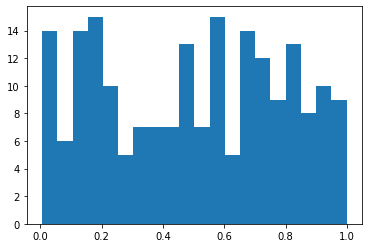

In [13]:
# 2D Gaussian with a standard deviation of 0.5 pixels
jitters = np.random.normal(scale=stdev, size=2*N).reshape(N, 2)
with open("{}/jitter.csv".format(sim_name), 'w') as f:
    f.write("t,x\n")
    for i in range(N):
        f.write("{},{},{}\n".format(i, jitters[i,0],jitters[i,1]))

In [57]:
A_coords_xy = jitters
B_coords_xy = coords + jitters

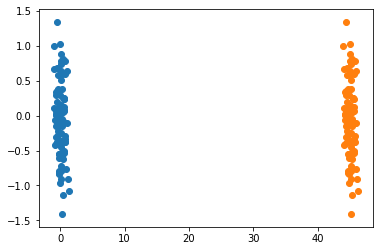

In [58]:
plt.scatter(A_coords_xy[:,0], A_coords_xy[:,1])
plt.scatter(B_coords_xy[:,0], B_coords_xy[:,1])

In [59]:
A_rs = (A_coords_xy[:,0]**2 + A_coords_xy[:,1]**2)**0.5
B_rs = (B_coords_xy[:,0]**2 + B_coords_xy[:,1]**2)**0.5

A_phis = np.arctan2(A_coords_xy[:,1], A_coords_xy[:,0])
B_phis = np.arctan2(B_coords_xy[:,1], B_coords_xy[:,0])

0.0


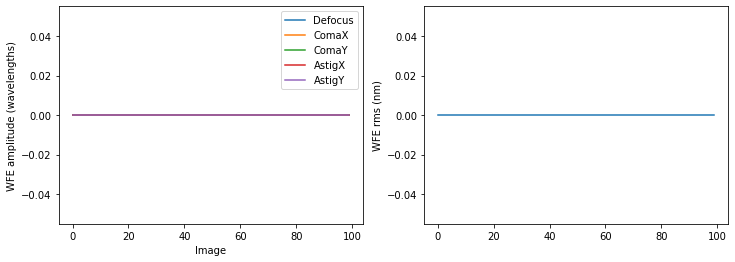

In [60]:
# Wavefront error!
# Generate from a random walk
np.random.seed(seed+1)# +1 so we don't get correlated jitters and defocus

defocus_amount = 0.00 * central_wavelength
coma_amount = 0.00 * central_wavelength
astig_amount = 0.00 * central_wavelength

wfe_rms = np.zeros(N)
defocus_amps = np.zeros(N)
coma_amps = np.zeros((N,2))
astig_amps = np.zeros((N,2))
last_defocus = 0
last_coma = [0,0]
last_astig = [0,0]
for ix in range(N):
    next_defocus = np.random.normal(loc=last_defocus,scale=defocus_amount)
    defocus_amps[ix] = next_defocus
    last_defocus = next_defocus
    
    next_coma = np.random.normal(loc=last_coma,scale=coma_amount,size=2)
    coma_amps[ix] = next_coma
    last_coma = next_coma
    
    next_astig = np.random.normal(loc=last_astig,scale=astig_amount,size=2)
    astig_amps[ix] = next_astig
    last_astig = next_astig

# Make a random point zero
defocus_amps -= np.random.choice(defocus_amps)
coma_amps[:,0] -= np.random.choice(coma_amps[:,0])
coma_amps[:,1] -= np.random.choice(coma_amps[:,1])
astig_amps[:,0] -= np.random.choice(astig_amps[:,0])
astig_amps[:,1] -= np.random.choice(astig_amps[:,1])
    
# Measure the RMS WFE on each image
for ix in range(N):
    wfe_terms = {(0,2):defocus_amps[ix],(-1,3):coma_amps[ix,0],(1,3):coma_amps[ix,1],
                      (-2,2):astig_amps[ix,0],(2,2):astig_amps[ix,1]}
    wfe_map = functions.add_zernikes(wfe_terms,[256,256])
    wfe_rms[ix] = np.sqrt(np.mean(wfe_map**2))


plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(defocus_amps/central_wavelength,label='Defocus')
plt.plot(coma_amps[:,0]/central_wavelength,label='ComaX')
plt.plot(coma_amps[:,1]/central_wavelength,label='ComaY')
plt.plot(astig_amps[:,0]/central_wavelength,label='AstigX')
plt.plot(astig_amps[:,1]/central_wavelength,label='AstigY')
plt.xlabel('Image')
plt.ylabel('WFE amplitude (wavelengths)')
plt.legend()

plt.subplot(122)
plt.plot(wfe_rms*1e9)
plt.ylabel('WFE rms (nm)')
print(np.median(wfe_rms*1e9))

# Save it in a dictionary to pass to the sims
wfe_terms = {'Defocus':defocus_amps,'Coma':coma_amps,'Astigmatism':astig_amps}

In [79]:
# Save all the important params
with open(sim_name+'/sim_parameters.txt','w') as file:
    file.write('Random seed: '+str(seed)+'\n')
    file.write('Central wavelength: '+str(central_wavelength)+'\n')
    file.write('Jitter (pix): '+str(stdev)+'\n')
    file.write('Signal size: '+str(signal_size)+'\n')
    file.write('Signal cycles: '+str(signal_cycles)+'\n')
    file.write('Dark Noise: '+str(dark_noise)+'\n')
    file.write('Peak Photons: '+str(peak_photons)+'\n')
    file.write('Defocus Amplitude (m): '+str(defocus_amount)+'\n')
    file.write('Coma Amplitude (m): '+str(coma_amount)+'\n')
    file.write('Astigmatism Amplitude (m): '+str(astig_amount)+'\n')
    file.write('Median RMS WFE (nm): '+str(np.median(wfe_rms*1e9))+'\n')

---
Pre-compute a series of pupils that will are pre-scaled to give the dersired FT array size for each wavelength

In [62]:
pupil_in = np.load("pupil_scaled.npy")
# pupil_in = formatter.pupil_from_fits("pupil.fits")
sizes = []

for wl in wavels:
    # Caclaute how big the pupil array needs to be to get our desired Fourier Transformed array size
    plate_scale = pix_size/focal_length    # Radians per pixel
    spatial_freq = (wl*1e-9)/aperture
    scale_factor = spatial_freq/plate_scale
    size_out = int(transform_size/scale_factor)
    sizes.append([size_out, wl,pupil_in,sim_name])

In [63]:
%%time
with mp.Pool(processes=n_cores) as pool:
# pool = mp.Pool(processes=n_cores)
    null = pool.map(functions.make_pupil, sizes)

CPU times: user 103 ms, sys: 102 ms, total: 204 ms
Wall time: 3.56 s


In [80]:
static = [aperture, m2_obsc, npix, focal_length, pix_size, transform_size,sim_name]
combination_inputs = [specA, specB, fpd]
inputs = []

for n in range(N):
    loop_wfe_terms = {(0,2):wfe_terms['Defocus'][n],
                      (-1,3):wfe_terms['Coma'][n,0],(1,3):wfe_terms['Coma'][n,1],
                      (-2,2):wfe_terms['Astigmatism'][n,0],(2,2):wfe_terms['Astigmatism'][n,1]}

    for wl in wavels:
        for i in range(2):
            if i %2 == 0:
                r = A_rs[n]
                phi = A_phis[n]
                star = "A"
            else:
                r = B_rs[n]
                phi = B_phis[n]
                star = "B"
                                
            dynamic = [n, wl, r, phi, star,loop_wfe_terms]
            inputs.append(static + dynamic)
    if (N > 500) and  (n % 100) == 0:
        print('Done {0} of {1}'.format(n,N))

In [81]:
%%time
# Put it in a with statement to close them automatically
with mp.Pool(processes=n_cores) as pool:
    # Do it in blocks of 100
    upto = 0
    while upto < len(inputs):
        null = pool.map(functions.model_image, inputs[upto:upto+100])
        upto += 100
        if (upto % 5000) == 0:
            print('Done {0} of {1}'.format(upto,len(inputs)))

Done 5000 of 20200
Done 10000 of 20200
Done 15000 of 20200
Done 20000 of 20200
CPU times: user 794 ms, sys: 216 ms, total: 1.01 s
Wall time: 15min 26s


In [90]:
# Combine images
peak_photons = 2500000 # photons
for n in range(100):
    # Add detector noise
    im_out =  np.abs(np.round(np.random.normal(scale=dark_noise, size=[npix, npix])))
    
    for i in range(len(wavels)):
        wl = wavels[i]
        countsA = specA[i]
        countsB = specB[i]
                
        PSF_A = np.load(sim_name+"/PSFs/{}_{}_A.npy".format(n, wl))
        PSF_B = np.load(sim_name+"/PSFs/{}_{}_B.npy".format(n, wl))
        
        im_out += countsA*PSF_A + countsB*PSF_B
        
    # Add photon noise
    im_out = functions.add_photon_noise(im_out,peak_photons=peak_photons)
    
    np.save(sim_name+"/images/{}.npy".format(n), im_out)
    fits.writeto(sim_name+"/images/{}.fits".format(n),im_out,overwrite=True)
    if (n % (N//10)) ==0:
        print('Done {0} of {1}'.format(n,N))
        
#     plt.imshow(im_out)

Done 0 of 100
Done 10 of 100
Done 20 of 100
Done 30 of 100
Done 40 of 100
Done 50 of 100
Done 60 of 100
Done 70 of 100
Done 80 of 100
Done 90 of 100


In [91]:
# How many photons were in the toliman pupil?
nphots_tol = []
nphots_full = []
for ix in range(100):
    im = np.load('sims/toliman_photon_noise/images/{0}.npy'.format(ix))
    nphots_tol.append(np.sum(im))
    
    im = np.load('sims/round_pupil_photon_noise/images/{0}.npy'.format(ix))
    nphots_full.append(np.sum(im))


print('Toliman:',np.mean(nphots_tol),np.median(nphots_tol))
print('Fullpupil:',np.mean(nphots_full),np.median(nphots_full))
print('Need to multiply by:',np.mean(nphots_tol)/np.mean(nphots_full),np.median(nphots_tol)/np.median(nphots_full))


Toliman: 45711035.09 45707483.5
Fullpupil: 45727717.57 45622607.5
Need to multiply by: 0.9996351779426896 1.001860393446385


In [ ]:
# test photon noise
from importlib import reload
reload(functions)
image = np.load('sims/jitter_only/images/0.npy')
image = functions.add_photon_noise(image,peak_photons=30000)

# add dark noise too
dark_noise = np.random.poisson(lam=0.1,size=image.shape)
image += dark_noise

# And flat field errors

plt.imshow(image**0.1)

In [38]:
# Save out sims with different numbers of photons
peak_photons_k = 100 # photons
sim_name_out = '/Users/cheetham/code/toliman/Toliman/COIN/sims/toliman_{0}k_photons'.format(peak_photons_k)
# os.makedirs(sim_name_out+'/images/')
peak_photons = peak_photons_k*1e3
print(sim_name_out)
for n in range(100):
    # Add detector noise
    im_out =  np.abs(np.round(np.random.normal(scale=dark_noise, size=[npix, npix])))
    a_out = 0*np.abs(np.round(np.random.normal(scale=dark_noise, size=[npix, npix])))
    b_out = 0*np.abs(np.round(np.random.normal(scale=dark_noise, size=[npix, npix])))
    
    for i in range(len(wavels)):
        wl = wavels[i]
        countsA = specA[i]
        countsB = specB[i]
                
        PSF_A = np.load(sim_name+"/PSFs/{}_{}_A.npy".format(n, wl))
        PSF_B = np.load(sim_name+"/PSFs/{}_{}_B.npy".format(n, wl))
        
        a_out += countsA*PSF_A
        b_out += countsB*PSF_B
        
        im_out += countsA*PSF_A + countsB*PSF_B
        
    # Add photon noise
    im_out = functions.add_photon_noise(im_out,peak_photons=peak_photons)
    
    # Photons in A vs B
    print('Photons in A/Photons in B:',np.sum(a_out)/np.sum(b_out))
    
    np.save(sim_name_out+"/images/{}.npy".format(n), im_out)
#     fits.writeto(sim_name+"/images/{}.fits".format(n),im_out,overwrite=True)
    if (n % (N//10)) ==0:
        print('Done {0} of {1}'.format(n,N))

/Users/cheetham/code/toliman/Toliman/COIN/sims/toliman_100k_photons
Photons in A/Photons in B: 3.9426651996358073
Done 0 of 100
Photons in A/Photons in B: 3.9426651996358064
Photons in A/Photons in B: 3.9426651996358064
Photons in A/Photons in B: 3.942665199635807
Photons in A/Photons in B: 3.9426651996358077
Photons in A/Photons in B: 3.942665199635806
Photons in A/Photons in B: 3.9426651996358064
Photons in A/Photons in B: 3.942665199635807
Photons in A/Photons in B: 3.9426651996358077
Photons in A/Photons in B: 3.942665199635807
Photons in A/Photons in B: 3.942665199635806
Done 10 of 100
Photons in A/Photons in B: 3.9426651996358064
Photons in A/Photons in B: 3.9426651996358077
Photons in A/Photons in B: 3.942665199635806
Photons in A/Photons in B: 3.9426651996358064
Photons in A/Photons in B: 3.9426651996358073
Photons in A/Photons in B: 3.9426651996358077
Photons in A/Photons in B: 3.9426651996358064
Photons in A/Photons in B: 3.9426651996358064
Photons in A/Photons in B: 3.942665

In [ ]:
# Derotate the images
import importlib
importlib.reload(functions)
for n in range(N):
# for n in [225]:
    im_in = np.load("test/normal_images/{}.npy".format(n))
    
    derot_angle = -phis[n]/np.pi*180
    im_out = functions.fft_rotate(im_in,derot_angle,pad=4)
        
#     np.save("test/derot_images/{}.npy".format(n), im_out)
    fits.writeto("test/derot_images/{}.fits".format(n),im_out,overwrite=True)
    if (n % 10) ==1:
        print('Done {} of {}'.format(n,N))